In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

In [223]:
df_tr = pd.read_csv('train.csv', index_col = 0)
df_test = pd.read_csv('test.csv', index_col = 0)
df_tr.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [224]:
df_tr['Label'] = 1
df_test['Label'] = 0
# its indicators of train and test size in addited sample
y = df_tr['SalePrice']
df_tr.drop('SalePrice', axis = 1, inplace = True)

In [225]:
df_tot = pd.concat([df_tr, df_test], axis = 0)
df_tot.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Label
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,1
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,1


# Preprocessing features

### Fill gaps

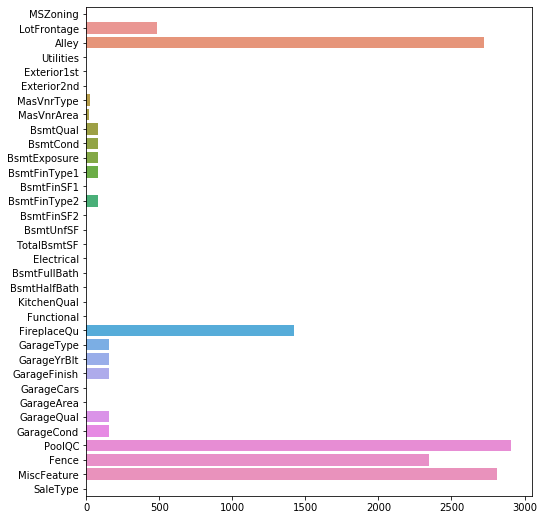

In [226]:
plt.figure(figsize = (8, 9))
sns.barplot(x = df_tot.isnull().sum()[df_tot.isnull().sum() > 0].values, 
            y = df_tot.isnull().sum()[df_tot.isnull().sum() > 0].index)
plt.show()

In [227]:
list_sm_notnan = list(df_tot.isnull().sum()[df_tot.isnull().sum()/len(df_tot.index) > 0.8].index)
df_tot.drop(list_sm_notnan, axis = 1, inplace = True)

In [228]:
df_tot.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Label
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,1


In [229]:
cat_df = df_tot.select_dtypes(include=['object'])
num_df =df_tot.select_dtypes(exclude=['object'])

### Categorical data

In [230]:
cat_df.shape

(2919, 39)

In [231]:
cat_df.isnull().sum()[cat_df.isnull().sum() > 0]

MSZoning           4
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
SaleType           1
dtype: int64

In [232]:
col_fill_new = list(cat_df.isnull().sum()[cat_df.isnull().sum() > 50].index)
cat_df[col_fill_new]= cat_df[col_fill_new].fillna('Not known')
col_fill_mode = list(cat_df.isnull().sum()[cat_df.isnull().sum() < 50].index)
for col in col_fill_mode:
    mode = cat_df[col].value_counts().index[0]
    cat_df[col] = cat_df[col].apply(lambda x: mode if x!=x else x)

In [233]:
var_ser = pd.Series()
for col in cat_df.columns:
    var_ser[col] = np.var(LabelEncoder().fit_transform(cat_df[col]))
# note features with a very low variance
var_ser[var_ser < 0.5]

MSZoning       0.433283
Street         0.004094
LandContour    0.495996
Utilities      0.000342
LandSlope      0.061855
Condition2     0.043846
RoofMatl       0.290648
MasVnrType     0.366423
ExterQual      0.492979
Heating        0.060337
CentralAir     0.062638
PavedDrive     0.288591
dtype: float64

In [234]:
for col in var_ser[var_ser < 0.5].index:
    print(cat_df[col].value_counts())

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Roll          1
ClyTile       1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64
None       1766
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64
TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64
GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64
Y    2723
N     196
Name: CentralAir, dtype

<i>As we can observe features Street, Utilities, Condition2, RoofMatl, Heating have low variance and count other values another main is very small(< 30)

In [235]:
cat_df.drop(["Street", "Utilities", "Condition2", "RoofMatl", "Heating"], axis = 1, inplace = True)

### Numerical data

In [236]:
num_df.isnull().sum()[num_df.isnull().sum() > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [237]:
# GarageYrBlt and LotFrontage fill medians, other fill zeros
num_df['LotFrontage'] = num_df['LotFrontage'].fillna(num_df['LotFrontage'].median())
num_df['GarageYrBlt'] = num_df['GarageYrBlt'].fillna(num_df['GarageYrBlt'].median())

In [238]:
num_df.fillna(0, inplace = True)

### New feature

In [240]:
num_df['Age_bulding'] = num_df['YrSold'] - num_df['YearBuilt']
num_df['Age_bulding'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_bulding, dtype: float64

In [241]:
# can create more usefull features

In [242]:
num_df.loc[num_df['Age_bulding'] < 0, 'YrSold'] = num_df.loc[num_df['Age_bulding'] < 0, 'YrSold'] + 1
num_df['Age_bulding'] = num_df['YrSold'] - num_df['YearBuilt']
num_df['Age_bulding'].describe()

count    2919.000000
mean       36.480301
std        30.335764
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_bulding, dtype: float64

In [273]:
num_df['Car_x_Square'] = num_df.GarageArea * num_df.GarageCars 

for col in num_df.columns:
    if col != 'Label':
        num_df[col] = (num_df[col] - num_df[col].mean())/num_df[col].std()

## Encode cat features

In [244]:
for col in cat_df:
    display(col, cat_df[col].unique())

'MSZoning'

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

'LotShape'

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

'LandContour'

array(['Lvl', 'Bnk', 'Low', 'HLS'], dtype=object)

'LotConfig'

array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object)

'LandSlope'

array(['Gtl', 'Mod', 'Sev'], dtype=object)

'Neighborhood'

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

'Condition1'

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

'BldgType'

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

'HouseStyle'

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

'RoofStyle'

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

'Exterior1st'

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

'Exterior2nd'

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

'MasVnrType'

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

'ExterQual'

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

'ExterCond'

array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

'Foundation'

array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object)

'BsmtQual'

array(['Gd', 'TA', 'Ex', 'Not known', 'Fa'], dtype=object)

'BsmtCond'

array(['TA', 'Gd', 'Not known', 'Fa', 'Po'], dtype=object)

'BsmtExposure'

array(['No', 'Gd', 'Mn', 'Av', 'Not known'], dtype=object)

'BsmtFinType1'

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'Not known', 'LwQ'],
      dtype=object)

'BsmtFinType2'

array(['Unf', 'BLQ', 'Not known', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
      dtype=object)

'HeatingQC'

array(['Ex', 'Gd', 'TA', 'Fa', 'Po'], dtype=object)

'CentralAir'

array(['Y', 'N'], dtype=object)

'Electrical'

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

'KitchenQual'

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

'Functional'

array(['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'], dtype=object)

'FireplaceQu'

array(['Not known', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

'GarageType'

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Not known', 'Basment',
       '2Types'], dtype=object)

'GarageFinish'

array(['RFn', 'Unf', 'Fin', 'Not known'], dtype=object)

'GarageQual'

array(['TA', 'Fa', 'Gd', 'Not known', 'Ex', 'Po'], dtype=object)

'GarageCond'

array(['TA', 'Fa', 'Not known', 'Gd', 'Po', 'Ex'], dtype=object)

'PavedDrive'

array(['Y', 'N', 'P'], dtype=object)

'SaleType'

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
      dtype=object)

'SaleCondition'

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

<i>We can see a few features, which have same values with {'TA', 'Fa', 'Gd', 'Not known', 'Ex', 'Po'} or {'Y', 'N'}

In [245]:
for col in cat_df:
    if 'Gd' in cat_df[col].unique():
        cat_df[col] = cat_df[col].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Av': 2, 'Fa': 1, 'Po': 1, 
                                       'Mn': 1, 'No': 1, 'Not known': 0})
    elif 'BLQ' in cat_df[col].unique():
        cat_df[col] = cat_df[col].map({'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6, 'Not known': 0})
        
    elif 'Y' in cat_df[col].unique():
        cat_df[col] = cat_df[col].map({'Y': 2, 'P': 1, 'N': 0})

In [246]:
cat_df = pd.get_dummies(cat_df, columns = cat_df.select_dtypes('O').columns)
cat_df.index = pd.Index(range(1, 2920))
cat_df.isnull().sum().sum(), cat_df.shape, cat_df.index

(0, (2919, 167), RangeIndex(start=1, stop=2920, step=1))

In [247]:
df_tot = pd.concat([num_df, cat_df], axis = 1)
df_tot.shape, df_tot.isnull().sum().sum()

((2919, 206), 0)

In [248]:
train_df = df_tot[df_tot.Label == 1]
test_df = df_tot[df_tot.Label == 0]
del df_tot
train_df.shape, test_df.shape, y.shape

((1460, 206), (1459, 206), (1460,))

# Modeling

In [249]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

In [266]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, train_size = 0.4)
scor = {'Squared_error': metrics.make_scorer(metrics.mean_squared_error), 
        'Absolute_error': metrics.make_scorer(metrics.mean_absolute_error),
        'r2': metrics.make_scorer(metrics.r2_score)}

xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6, gamma=0,
                     importance_type='gain', learning_rate=0.01, max_delta_step=0,
                     max_depth=4, min_child_weight=1.5, n_estimators=1400,
                     n_jobs=1, nthread=None, objective='reg:linear',
                     reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
                     silent=None, subsample=0.8, verbosity=1)

In [267]:
mas_cr = cross_validate(xgb, X_train, y_train, cv = 5, scoring = scor)
mas_cr

[16:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'fit_time': array([4.15055585, 4.04838848, 4.04241347, 4.28113532, 4.42940116]),
 'score_time': array([0.01562452, 0.01562047, 0.01396275, 0.01612473, 0.01695609]),
 'test_Squared_error': array([8.40030369e+08, 2.35740546e+08, 7.42973118e+08, 3.39671513e+08,
        8.11095108e+08]),
 'test_Absolute_error': array([15756.5637687 , 11734.44497863, 18881.63902244, 13811.32992788,
        18917.24983163]),
 'test_r2': array([0.89933692, 0.95222681, 0.92061406, 0.91530887, 0.89749416])}

In [268]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred)), metrics.mean_absolute_error(y_test, y_pred), metrics.r2_score(y_test, y_pred)

[16:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(32917.6594437316, 16772.302159139555, 0.8152717929915213)

In [269]:
xgb.fit(train_df, y)
answ_y = xgb.predict(test_df)

[16:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [270]:
ans = pd.DataFrame({'Id': list(range(1461, 2920)), 'SalePrice': answ_y})

In [271]:
ans

,Id,SalePrice
0,1461,125681.062500
1,1462,162203.515625
2,1463,180998.828125
3,1464,189103.921875
4,1465,188100.843750
...,...,...
1454,2915,82993.289062
1455,2916,79945.828125
1456,2917,160240.281250
1457,2918,120359.273438


In [272]:
ans.to_csv('Rofl_answ.csv', index = False)

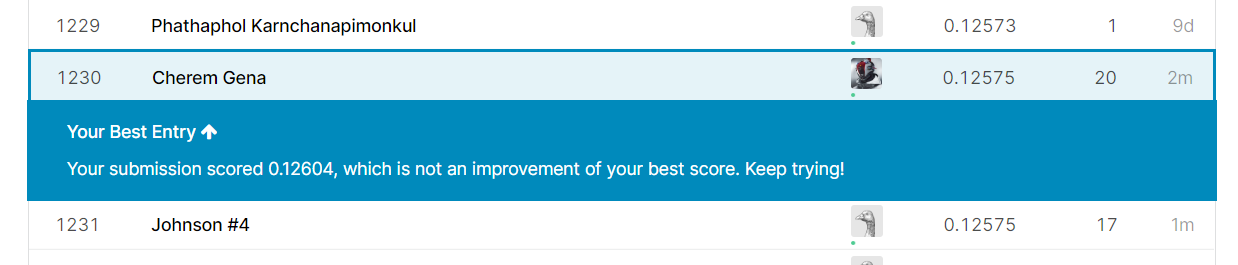